# Data Exploratory Analysis

#### Resolving Dependencies

In [ ]:
%pip install datasets
%pip install torch torchvision torchaudio
%pip install transformers
%pip install faiss-cpu faiss-gpu   # faiss-gpu if using GPU
%pip install Pillow numpy scikit-learn
%pip install git+https://github.com/facebookresearch/segment-anything.git  # Optional for segmentation
%pip install --upgrade peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!mkdir flickr30k && cd flickr30k
# Download the Flickr30k dataset
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!tar -xvzf Flickr8k_Dataset.zip

# Download the Flickr30k annotations
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!tar -xvzf Flickr8k_text.zip

mkdir: cannot create directory ‘flickr30k’: File exists


--2025-06-02 19:20:24--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 18.220.149.166
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-02 19:20:24 ERROR 404: Not Found.

tar (child): Flickr8k_Dataset.zip: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
--2025-06-02 19:20:25--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 18.220.149.166
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-02 19:20:25 ERROR 404: Not Found.

tar (child): Flickr8k_text.zip: Cannot open: No such file or d

#### Importing Libraries

In [1]:
import gc
import torch
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import faiss
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import glob
import pickle
import numpy as np
from peft import get_peft_model, LoraConfig, TaskType

/bigdata/chaturvedilab/shared/EvoCell/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load flickr30k dataset
ds = load_dataset("nlphuji/flickr30k", cache_dir="./.hf_cache", data_dir=".")
# train_data = ds["test"]
train_data = ds["test"].select(range(2000))  # Just 2000 images for now

In [3]:
# Basic PyTorch-style DataLoader (batch_size 1 for simplicity)
def collate_fn(batch):
    images = [sample["image"] for sample in batch]
    texts = [sample["caption"][0] for sample in batch]  # use first caption
    paths = [sample["filename"] for sample in batch]    # get filenames here
    return images, texts, paths

loader = DataLoader(train_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name, cache_dir="./.cache", trust_remote_code=True, use_safetensors=True).to(DEVICE)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
print(ds["test"][0])  # or ds["train"][0] depending on your split

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x7FEF323F6E80>, 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg'}


1000092795.jpg


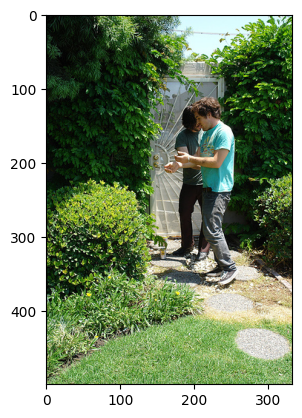

In [6]:
# Display the first image in the dataset using PIL
images, texts, paths = next(iter(loader))
print(paths[0])  # prints e.g. '1000092795.jpg'
plt.imshow(images[0])

In [10]:
chunk_size = 5000
save_dir = "./image_chunks"
image_save_dir = "./flickr30k-test-images"  # where we'll save actual JPGs
os.makedirs(save_dir, exist_ok=True)
os.makedirs(image_save_dir, exist_ok=True)

chunk_id = 0
image_embeddings = []
text_data = []
image_paths = []

print("📦 Encoding and saving image embeddings in chunks...")

for i, (images, texts, filenames) in enumerate(tqdm(loader)):
    image = images[0]
    text = texts[0]
    filename = filenames[0]
    full_path = os.path.join(image_save_dir, filename)

    try:
        # Save image to disk once
        if not os.path.exists(full_path):
            image.save(full_path)

        # Encode with CLIP
        inputs = clip_processor(images=image, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        with torch.no_grad():
            img_embed = clip_model.get_image_features(**inputs)

        image_embeddings.append(img_embed.cpu().numpy())
        text_data.append(text)
        image_paths.append(full_path)

        # Cleanup
        del inputs, img_embed
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"❌ Error processing sample {i}: {e}")
        continue

    # Save chunk
    if (i + 1) % chunk_size == 0:
        print(f"💾 Saving chunk {chunk_id} with {len(image_embeddings)} items")
        image_embeddings_np = np.concatenate(image_embeddings, axis=0).astype("float32")
        faiss.normalize_L2(image_embeddings_np)

        np.save(os.path.join(save_dir, f"embeddings_chunk_{chunk_id}.npy"), image_embeddings_np)
        with open(os.path.join(save_dir, f"metadata_chunk_{chunk_id}.pkl"), "wb") as f:
            pickle.dump({"texts": text_data, "paths": image_paths}, f)

        # Reset
        image_embeddings = []
        text_data = []
        image_paths = []
        chunk_id += 1

📦 Encoding and saving image embeddings in chunks...


100%|██████████| 2000/2000 [05:25<00:00,  6.15it/s]


In [11]:
# Save remaining samples
if image_embeddings:
    print(f"💾 Saving final chunk {chunk_id} with {len(image_embeddings)} items")
    image_embeddings_np = np.concatenate(image_embeddings, axis=0).astype("float32")
    faiss.normalize_L2(image_embeddings_np)

    np.save(os.path.join(save_dir, f"embeddings_chunk_{chunk_id}.npy"), image_embeddings_np)
    with open(os.path.join(save_dir, f"metadata_chunk_{chunk_id}.pkl"), "wb") as f:
        pickle.dump({"texts": text_data, "paths": image_paths}, f)

print("✅ All chunks saved successfully.")

💾 Saving final chunk 0 with 2000 items
✅ All chunks saved successfully.


In [7]:
import glob
import pickle
import numpy as np
import faiss
import os

# === Step 1: Load all metadata ===
text_data = []
image_paths = []

metadata_files = sorted(glob.glob("./image_chunks/metadata_chunk_*.pkl"))
if not metadata_files:
    raise FileNotFoundError("❌ No metadata files found in ./image_chunks")

for meta_file in metadata_files:
    with open(meta_file, "rb") as f:
        meta = pickle.load(f)
        text_data.extend(meta["texts"])
        image_paths.extend(meta["paths"])

# === Step 2: Load all embedding chunks ===
embedding_files = sorted(glob.glob("./image_chunks/embeddings_chunk_*.npy"))
if not embedding_files:
    raise FileNotFoundError("❌ No embedding .npy files found in ./image_chunks")

all_embeddings = []
for emb_file in embedding_files:
    emb_chunk = np.load(emb_file)
    all_embeddings.append(emb_chunk)

# === Step 3: Concatenate and validate ===
image_embeddings = np.concatenate(all_embeddings, axis=0).astype("float32")

print(f"📦 Loaded {len(text_data)} texts")
print(f"🖼️ Loaded {len(image_paths)} image paths")
print(f"📊 Loaded {image_embeddings.shape[0]} embeddings of dim {image_embeddings.shape[1]}")

assert len(text_data) == len(image_paths) == image_embeddings.shape[0], \
    "❌ Mismatch: Number of texts, image paths, and embeddings must be equal!"

# === Step 4: Normalize and build FAISS index ===
faiss.normalize_L2(image_embeddings)
index = faiss.IndexFlatIP(image_embeddings.shape[1])
index.add(image_embeddings)

print(f"✅ FAISS index built with {index.ntotal} vectors.")

📦 Loaded 2000 texts
🖼️ Loaded 2000 image paths
📊 Loaded 2000 embeddings of dim 512
✅ FAISS index built with 2000 vectors.


In [13]:
import faiss

# === Ensure input is valid ===
assert len(image_embeddings.shape) == 2, "image_embeddings must be 2D"
assert image_embeddings.dtype == np.float32, "image_embeddings must be float32"

# === Normalize embeddings for cosine similarity ===
faiss.normalize_L2(image_embeddings)

# === Build FAISS index using inner product (normalized = cosine similarity) ===
index = faiss.IndexFlatIP(image_embeddings.shape[1])
index.add(image_embeddings)

print(f"✅ FAISS index built: {index.ntotal} vectors, dim {image_embeddings.shape[1]}")

✅ FAISS index built: 2000 vectors, dim 512


In [14]:
from PIL import Image
import torch
import faiss
import os

def retrieve_similar_images(image_query, top_k=5):
    """
    Retrieves top_k most similar images (from indexed dataset) to the given image query.
    
    Parameters:
        image_query (str or PIL.Image.Image): The input query image (path or object).
        top_k (int): Number of similar results to retrieve.
    """
    # Load image from path if necessary
    if isinstance(image_query, str):
        if not os.path.exists(image_query):
            print(f"❌ Image path does not exist: {image_query}")
            return
        image = Image.open(image_query).convert("RGB")
    elif isinstance(image_query, Image.Image):
        image = image_query
    else:
        print("❌ Invalid image input: must be PIL.Image or valid path.")
        return

    # Preprocess and encode
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        query_emb = clip_model.get_image_features(**inputs)
    query_emb = query_emb.cpu().numpy().astype("float32")
    faiss.normalize_L2(query_emb)

    # Search FAISS index
    scores, indices = index.search(query_emb, top_k)
    print(f"\n🔍 Image Query Results (Top {top_k}):\n")

    for i, idx in enumerate(indices[0]):
        if idx < len(text_data) and idx < len(image_paths):
            print(f"Rank {i+1}:")
            print(f"   Caption: {text_data[idx]}")
            print(f"   Path   : {image_paths[idx]}")
        else:
            print(f"Rank {i+1}: [Index {idx} out of bounds]")

    return indices  # Return the indices for optional downstream use

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_retrieved_images_from_paths(indices, num_images=5):
    """
    Display top-k retrieved images from the paths list using the given indices.

    Parameters:
        indices (List[List[int]]): FAISS-style list of lists of indices (e.g., [[3, 14, 8]])
        num_images (int): Number of top images to display
    """
    num_to_display = min(num_images, len(indices[0]))
    fig, axes = plt.subplots(1, num_to_display, figsize=(5 * num_to_display, 5))

    # Handle single subplot edge case
    if num_to_display == 1:
        axes = [axes]

    for i in range(num_to_display):
        idx = indices[0][i]
        if idx < len(image_paths) and os.path.exists(image_paths[idx]):
            try:
                img = Image.open(image_paths[idx]).convert("RGB")
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"Rank {i+1}")
            except Exception as e:
                print(f"❌ Error loading image at {image_paths[idx]}: {e}")
                axes[i].axis('off')
        else:
            print(f"⚠️ Invalid index or missing path for idx={idx}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
def retrieve_images_by_text_return_indices(text_query, top_k=5):
    """
    Retrieves indices of images most relevant to the given text query using CLIP + FAISS.

    Parameters:
        text_query (str): Text to search with.
        top_k (int): Number of top results to return.

    Returns:
        List[List[int]]: A 2D list of valid indices (like FAISS returns).
    """
    # Tokenize and encode text
    inputs = clip_processor(text=[text_query], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        text_emb = clip_model.get_text_features(**inputs)
    text_emb = text_emb.cpu().numpy().astype("float32")
    faiss.normalize_L2(text_emb)

    # Search FAISS index
    scores, indices = index.search(text_emb, top_k * 5)  # Retrieve more to filter invalid ones

    print(f"\n🔍 Text Query Results for: \"{text_query}\"\n")

    valid_indices = []
    for i, idx in enumerate(indices[0]):
        if idx < len(text_data) and idx < len(image_paths) and os.path.exists(image_paths[idx]):
            print(f"Rank {len(valid_indices)+1}:")
            print(f"   Caption: {text_data[idx]}")
            print(f"   Path   : {image_paths[idx]}")
            valid_indices.append(idx)
            if len(valid_indices) >= top_k:
                break
        else:
            print(f"⚠️ Rank {i+1}: [Index {idx} out of bounds or missing image path]")

    if not valid_indices:
        print("❌ No valid results found for the text query.")

    return [valid_indices]  # Keep 2D shape for compatibility

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_retrieved_images_from_paths(indices, num_images=5):
    """
    Display top-k retrieved images using image paths and FAISS indices.

    Parameters:
        indices (List[List[int]]): 2D list of indices (FAISS-style)
        num_images (int): Number of images to attempt to display
    """
    retrieved = indices[0]
    num_to_display = min(num_images, len(retrieved))

    fig, axes = plt.subplots(1, num_to_display, figsize=(5 * num_to_display, 5))

    # Handle single image display case
    if num_to_display == 1:
        axes = [axes]

    for i in range(num_to_display):
        idx = retrieved[i]
        if idx < len(image_paths) and os.path.exists(image_paths[idx]):
            try:
                img = Image.open(image_paths[idx]).convert("RGB")
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"Rank {i+1}")
            except Exception as e:
                print(f"❌ Error loading image at {image_paths[idx]}: {e}")
                axes[i].axis('off')
        else:
            print(f"⚠️ Skipping invalid or missing path at index {idx}")
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Retrieval System using CLIP


🔍 Text Query Results for: "A child playing in the sand"

Rank 1:
   Caption: A young girl and boy in swimsuits happily play in the sand on a beach.
   Path   : ./flickr30k-test-images/1332867233.jpg
Rank 2:
   Caption: Older man in a hat, yellow shirt and dress slacks playing in the sand with a young boy.
   Path   : ./flickr30k-test-images/11131022.jpg
Rank 3:
   Caption: A man, wearing a high pressure water machine on his back is sculpting a monument of jesus christ.
   Path   : ./flickr30k-test-images/1449758127.jpg
Rank 4:
   Caption: Two boys wearing red jackets are digging shovels into the dirt, the smaller boy in the yellow boots has a mohawk.
   Path   : ./flickr30k-test-images/150411291.jpg
Rank 5:
   Caption: A young child is jumping in the air in front of a large body of water as the sun sets.
   Path   : ./flickr30k-test-images/1371076688.jpg


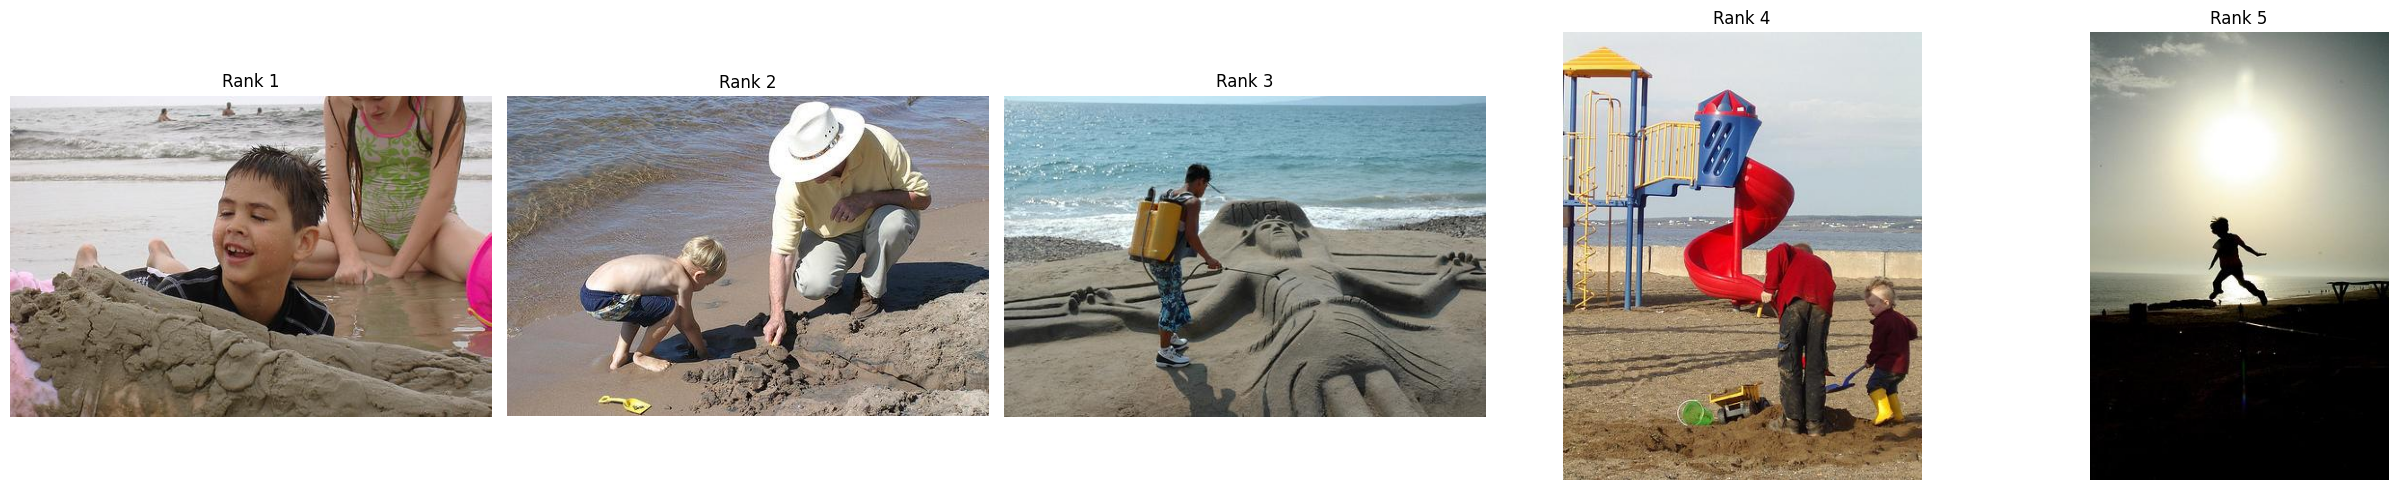

In [18]:
# Example usage for text query
query = "A child playing in the sand"
top_k = 5

indices = retrieve_images_by_text_return_indices(query, top_k=top_k)
display_retrieved_images_from_paths(indices, num_images=top_k)

In [19]:
# Example usage for image query

import os

# Find the first valid image path that exists on disk
sample_image_path = next((p for p in image_paths if p and os.path.exists(p)), None)

if sample_image_path:
    retrieve_similar_images(sample_image_path, top_k=5)
else:
    print("No valid image path found in image_paths.")


🔍 Image Query Results (Top 5):

Rank 1:
   Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard.
   Path   : ./flickr30k-test-images/1000092795.jpg
Rank 2:
   Caption: A young woman is laying in the grass with her eyes closed.
   Path   : ./flickr30k-test-images/1480467399.jpg
Rank 3:
   Caption: A person sitting on a ledge with a letter in their hands.
   Path   : ./flickr30k-test-images/1350936809.jpg
Rank 4:
   Caption: A man wearing an orange shirt and a baseball glove has just thrown a ball.
   Path   : ./flickr30k-test-images/1433154463.jpg
Rank 5:
   Caption: A woman in jeans and a tank top is sitting in the middle of a tree in bloom.
   Path   : ./flickr30k-test-images/1460352062.jpg


In [22]:
# === Step 6: Encode Texts with CLIP ===
print("✍️ Encoding text descriptions...")
# Use the tokenizer from clip_processor
text_tokens = clip_processor.tokenizer(
    text_data, padding=True, truncation=True, return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    text_embeddings = []
    batch_size = 64
    for i in tqdm(range(0, len(text_data), batch_size)):
        batch = {k: v[i:i + batch_size] for k, v in text_tokens.items()}
        text_feat = clip_model.get_text_features(**batch)
        text_feat /= text_feat.norm(dim=-1, keepdim=True)
        text_embeddings.append(text_feat.cpu().numpy())

text_embeddings = np.concatenate(text_embeddings, axis=0).astype("float32")
assert text_embeddings.shape[0] == image_embeddings.shape[0], "Text and image count mismatch"

# === Step 7: Evaluate Retrieval ===
def evaluate_top_k(text_embeds, index, top_k_percent):
    num_images = index.ntotal
    top_k = max(1, int(num_images * (top_k_percent / 100.0)))
    correct = 0

    print(f"\n🔍 Evaluating Top-{top_k_percent}% Accuracy (Top-{top_k})...\n")

    _, retrieved_indices = index.search(text_embeds, top_k)

    for i, retrieved in enumerate(retrieved_indices):
        if i in retrieved:
            correct += 1

    accuracy = correct / len(text_embeds)
    return accuracy

top1_percent_acc = evaluate_top_k(text_embeddings, index, top_k_percent=1)
top5_percent_acc = evaluate_top_k(text_embeddings, index, top_k_percent=5)

print(f"🎯 Top-1% Accuracy: {top1_percent_acc * 100:.2f}%")
print(f"🎯 Top-5% Accuracy: {top5_percent_acc * 100:.2f}%")

✍️ Encoding text descriptions...


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:01<00:00, 29.50it/s]



🔍 Evaluating Top-1% Accuracy (Top-20)...


🔍 Evaluating Top-5% Accuracy (Top-100)...

🎯 Top-1% Accuracy: 93.75%
🎯 Top-5% Accuracy: 98.85%



🔍 Evaluating Top-1% Accuracy (Top-20)...


🔍 Evaluating Top-2% Accuracy (Top-40)...


🔍 Evaluating Top-3% Accuracy (Top-60)...


🔍 Evaluating Top-4% Accuracy (Top-80)...


🔍 Evaluating Top-5% Accuracy (Top-100)...


🔍 Evaluating Top-6% Accuracy (Top-120)...


🔍 Evaluating Top-7% Accuracy (Top-140)...


🔍 Evaluating Top-8% Accuracy (Top-160)...


🔍 Evaluating Top-9% Accuracy (Top-180)...


🔍 Evaluating Top-10% Accuracy (Top-200)...



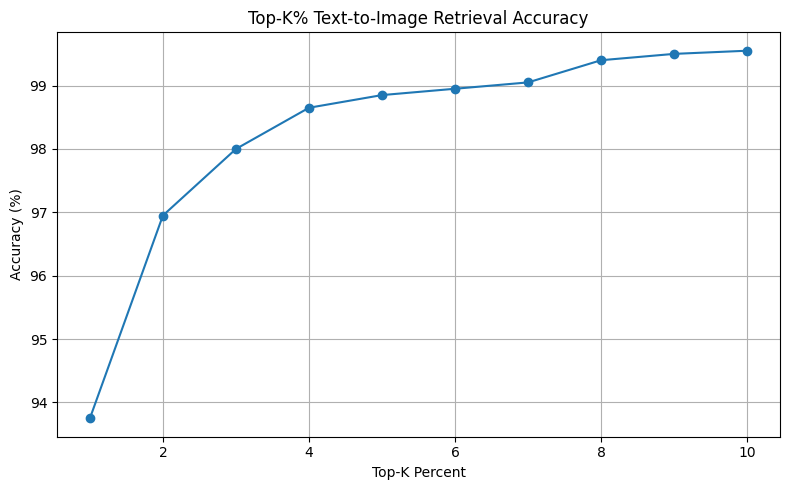

In [23]:
import matplotlib.pyplot as plt

top_k_percents = list(range(1, 11))  # From 1% to 10%
accuracies = []

for k in top_k_percents:
    acc = evaluate_top_k(text_embeddings, index, top_k_percent=k)
    accuracies.append(acc * 100)

plt.figure(figsize=(8, 5))
plt.plot(top_k_percents, accuracies, marker='o')
plt.title("Top-K% Text-to-Image Retrieval Accuracy")
plt.xlabel("Top-K Percent")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

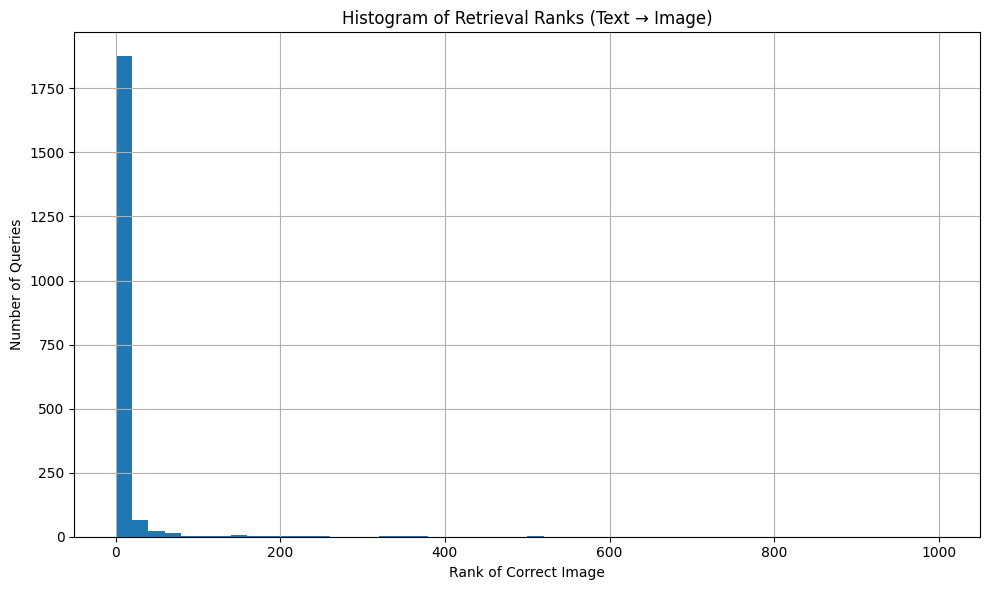

In [24]:
def get_ranks(text_embeddings, index):
    _, I = index.search(text_embeddings, index.ntotal)
    ranks = []
    for i, retrieved in enumerate(I):
        correct_rank = np.where(retrieved == i)[0]
        ranks.append(correct_rank[0] if len(correct_rank) > 0 else index.ntotal)
    return ranks

ranks = get_ranks(text_embeddings, index)

plt.figure(figsize=(10, 6))
plt.hist(ranks, bins=50, range=(0, min(index.ntotal, 1000)))
plt.title("Histogram of Retrieval Ranks (Text → Image)")
plt.xlabel("Rank of Correct Image")
plt.ylabel("Number of Queries")
plt.grid(True)
plt.tight_layout()
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


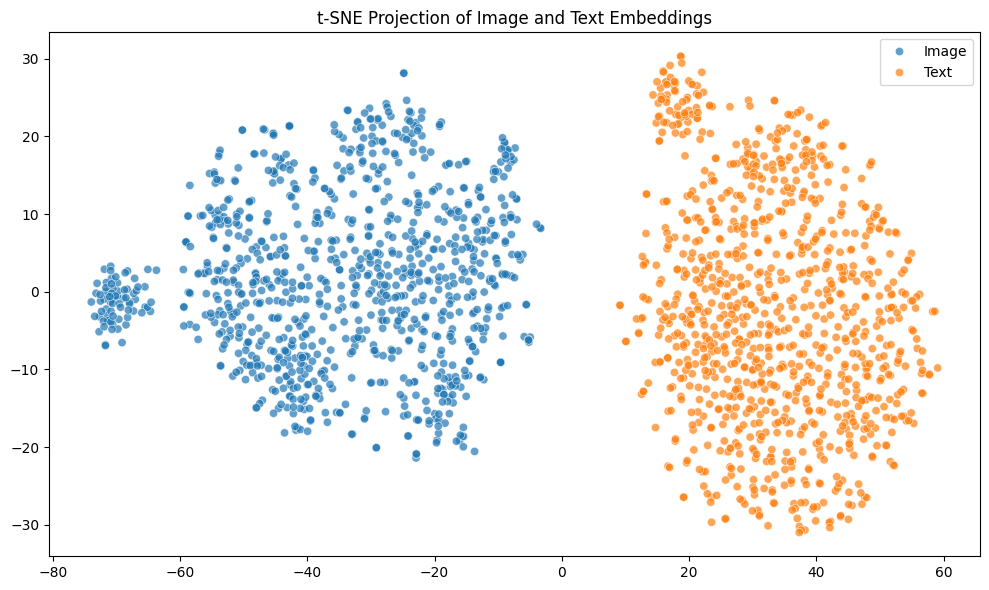

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

sample_size = 1000
indices = np.random.choice(len(image_embeddings), size=sample_size, replace=False)
sample_image_embeds = image_embeddings[indices]
sample_text_embeds = text_embeddings[indices]

combined = np.vstack((sample_image_embeds, sample_text_embeds))
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(combined)

labels = ["Image"] * sample_size + ["Text"] * sample_size

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, alpha=0.7)
plt.title("t-SNE Projection of Image and Text Embeddings")
plt.tight_layout()
plt.show()

## LORA

In [8]:
print(list(TaskType))

[<TaskType.SEQ_CLS: 'SEQ_CLS'>, <TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, <TaskType.CAUSAL_LM: 'CAUSAL_LM'>, <TaskType.TOKEN_CLS: 'TOKEN_CLS'>, <TaskType.QUESTION_ANS: 'QUESTION_ANS'>, <TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>]


In [9]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                        # Rank of LoRA matrices (tune for your task)
    lora_alpha=32,              # LoRA scaling parameter
    target_modules=["q_proj", "v_proj"],  # Transformer modules to apply LoRA to (query, value projections)
    task_type=TaskType.FEATURE_EXTRACTION,  # Use FEATURE_EXTRACTION since we are using the model to extract features and perform similarity search.
)

# Wrap the model with LoRA adapters
lora_model = get_peft_model(clip_model, lora_config)

In [10]:
target_modules = []
for name, module in clip_model.named_modules():
    if "proj" in name or "attn" in name:
        target_modules.append(name)

print(len(target_modules), "target modules found in CLIP model")

602 target modules found in CLIP model


There are 602 modules in your CLIP model whose names contain "proj" or "attn". That means there are plenty of candidates for LoRA injection 

In [11]:
attn_proj_modules = []
for name, module in clip_model.named_modules():
    if isinstance(module, torch.nn.Linear) and ("attn" in name or "proj" in name):
        attn_proj_modules.append(name)

print(len(attn_proj_modules), "attention and projection modules found in CLIP model")

194 attention and projection modules found in CLIP model


In [12]:
attn_proj_modules

['text_model.encoder.layers.0.self_attn.k_proj',
 'text_model.encoder.layers.0.self_attn.v_proj.base_layer',
 'text_model.encoder.layers.0.self_attn.v_proj.lora_A.default',
 'text_model.encoder.layers.0.self_attn.v_proj.lora_B.default',
 'text_model.encoder.layers.0.self_attn.q_proj.base_layer',
 'text_model.encoder.layers.0.self_attn.q_proj.lora_A.default',
 'text_model.encoder.layers.0.self_attn.q_proj.lora_B.default',
 'text_model.encoder.layers.0.self_attn.out_proj',
 'text_model.encoder.layers.1.self_attn.k_proj',
 'text_model.encoder.layers.1.self_attn.v_proj.base_layer',
 'text_model.encoder.layers.1.self_attn.v_proj.lora_A.default',
 'text_model.encoder.layers.1.self_attn.v_proj.lora_B.default',
 'text_model.encoder.layers.1.self_attn.q_proj.base_layer',
 'text_model.encoder.layers.1.self_attn.q_proj.lora_A.default',
 'text_model.encoder.layers.1.self_attn.q_proj.lora_B.default',
 'text_model.encoder.layers.1.self_attn.out_proj',
 'text_model.encoder.layers.2.self_attn.k_proj',

In [13]:
trainable_params = []
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        trainable_params.append(name)
print(f"Total trainable parameters in LoRA model: {len(trainable_params)}")

Total trainable parameters in LoRA model: 96


In [14]:
trainable_params

['base_model.model.text_model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight',
 'base_model.model.text_model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight',
 'base_model.model.text_model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight',
 'base_model.model.text_model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight',
 'base_model.model.text_model.encoder.layers.1.self_attn.v_proj.lora_A.default.weight',
 'base_model.model.text_model.encoder.layers.1.self_attn.v_proj.lora_B.default.weight',
 'base_model.model.text_model.encoder.layers.1.self_attn.q_proj.lora_A.default.weight',
 'base_model.model.text_model.encoder.layers.1.self_attn.q_proj.lora_B.default.weight',
 'base_model.model.text_model.encoder.layers.2.self_attn.v_proj.lora_A.default.weight',
 'base_model.model.text_model.encoder.layers.2.self_attn.v_proj.lora_B.default.weight',
 'base_model.model.text_model.encoder.layers.2.self_attn.q_proj.lora_A.default.weight',
 'base_model.model.text_model.en

#### Saving the Model

```python

In [15]:
print(type(lora_model))
print(lora_model.forward)

<class 'peft.peft_model.PeftModelForFeatureExtraction'>
<bound method PeftModelForFeatureExtraction.forward of PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): CLIPModel(
      (text_model): CLIPTextTransformer(
        (embeddings): CLIPTextEmbeddings(
          (token_embedding): Embedding(49408, 512)
          (position_embedding): Embedding(77, 512)
        )
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=512, out_features=512, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=512, out_features=512, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=512, out_features=8, bias=False)
                  )
         

In [16]:
lora_model.save_pretrained("clip-lora-adapter")

## Training Loop with Contrastive Loss

In [ ]:
# Optimizer — only LoRA params are trainable
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=1e-4)

lora_model.train()
num_epochs = 3  # adjust as needed

for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        # Unpack batch
        images, texts = batch[:2]

        # Tokenize and move to device
        inputs = clip_processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)

        # Move remaining tensors to device
        model_inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        # Remove unwanted keys such as inputs_embeds explicitly
        model_inputs.pop("inputs_embeds", None)

        # Forward pass
        outputs = lora_model(**model_inputs, return_dict=True)
        logits_per_image = outputs.logits_per_image  # [batch_size, batch_size]

        # Ground truth is diagonal (image i matches text i)
        ground_truth = torch.arange(len(images)).to(DEVICE)

        # Symmetric loss (like in original CLIP)
        loss_i2t = F.cross_entropy(logits_per_image, ground_truth)
        loss_t2i = F.cross_entropy(outputs.logits_per_text, ground_truth)
        loss = (loss_i2t + loss_t2i) / 2

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

inputs = clip_processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)
model_inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

outputs = lora_model(**model_inputs, return_dict=True)

TypeError: forward() got an unexpected keyword argument 'inputs_embeds'

#### Saving the Fine-Tuned LoRA Adapter

In [ ]:
lora_model.save_pretrained("clip-lora-flickr30k")

#### Loading the pre-training (before) Model

In [ ]:
from peft import PeftModel

base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
lora_model = PeftModel.from_pretrained(base_model, "clip-lora-adapter")

#### Freezing vision and text encoders selectively and only training one side.